In [1]:
import os
import re
# library for graphs
import networkx as nx
# library for numeric operations, math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
from networkx.drawing.nx_agraph import graphviz_layout

#from scipy.spatial.distance import squareform

In [2]:
class Person:
    def __init__(self, id, name, partner, father, mother):
        self.id = id
        self.name = name
        self.partner = partner
        self.father = father
        self.mother = mother
#function used by Python to print the information included into the class definition    
    def __str__(self):
        if self.mother != None:
            return self.id + ', ' + self.name + ', ' + " ".join(str(x) for x in self.partner) + ', ' + self.father + ', ' + self.mother
        else:
            return self.id + ', ' + self.name + ', ' + " ".join(str(x) for x in self.partner)

In [3]:
for filename in os.listdir():
    if '.csv' not in filename:
        continue
    file = open(filename,'r')
    
    #Header, first line containing the parameters
    file.readline()
    
    #Array to store family members
    members = []

#To obtain the info for each register
    for line in file:
        line = line.rstrip()
        if line:
            
            #Row (family member)
            parameters = re.split(r';', line)
            
            #They can have more than one partner (married more than once)
            partners = [] 
            if not parameters[2] == '':
                for p in parameters[2].split(','):
                    partners.append(p)
            
            #We don't have father nor mother
            if parameters[3] == '' and parameters[4] == '':
                members.append(Person(parameters[0],parameters[1],partners,None,None))
            else:
                members.append(Person(parameters[0],parameters[1],partners,parameters[3],parameters[4]))                           

In [4]:
#painting the tree - hierarchical
def draw_tree(G,filename):
    figure(num=None, figsize=(24, 18), dpi=100, facecolor='w', edgecolor='k')
    
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]

    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, edge_color=colors, with_labels = True)
    plt.savefig('images/tree_evolution/' + filename + '.png')
    plt.show()

In [5]:
def find_root_node(G):
    root = ''
    for node in G.nodes():
        degree = G.in_degree(node)
        if degree == 1:
            partner,node = list(G.in_edges(node))[0]
            if G.in_degree(partner) == 1:
                root = node
                return root
    

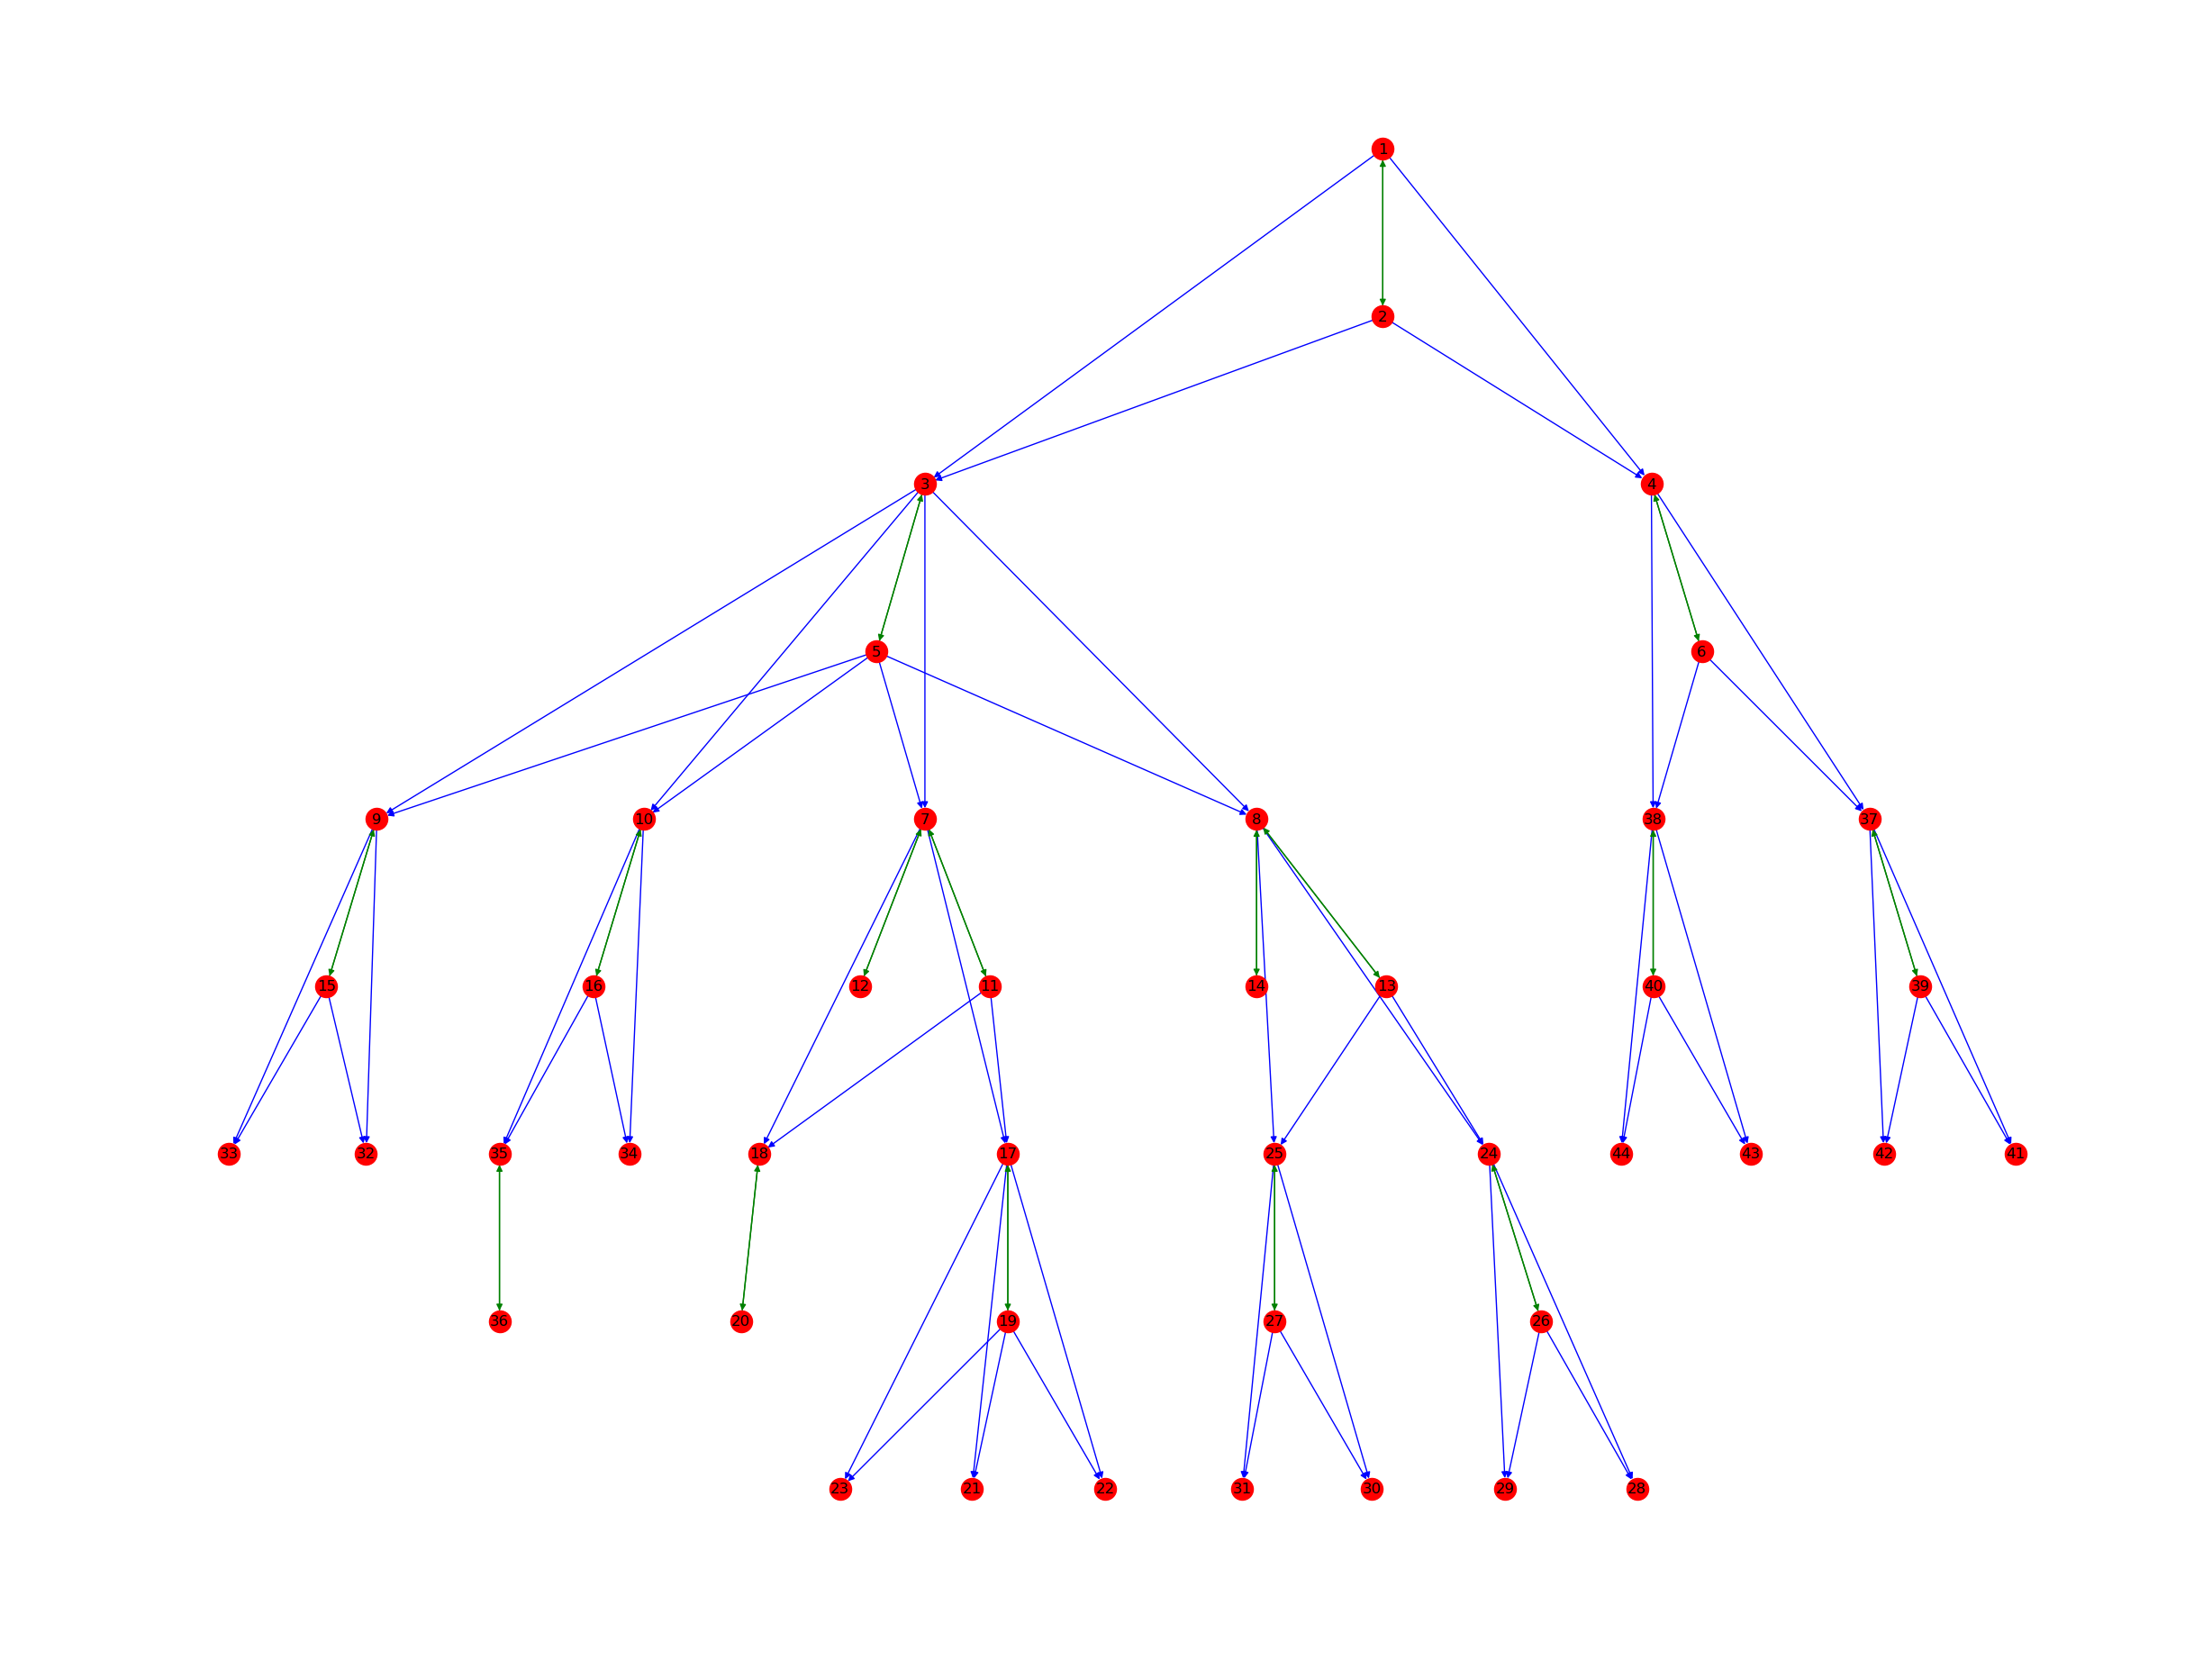

In [6]:
#to define a directed (with arrows) graph
G = nx.DiGraph()

#We add all the members to the network
for mem in members:
    G.add_node(mem.id)
    
#We add all partner associations
for mem in members:
    partners = mem.partner
    for p in partners:
        G.add_edge(mem.id,p,color='green')

#We add all the siblings associations
for mem in members:
    if mem.mother != None:
        G.add_edge(mem.mother,mem.id,color='blue')
        G.add_edge(mem.father,mem.id,color='blue')

#figure(num=None, figsize=(24, 18), dpi=100, facecolor='w', edgecolor='k')
#nx.draw_random(G, with_labels=True)
#plt.savefig('images/tree_random.png')
#plt.show()
draw_tree(G,'family_tree')

In [7]:
#2
#Transform graph to an adjacency matrix
A = nx.to_numpy_matrix(G)

#Tests made with undirected graphs
#A = A + A.transpose()
#Binarize
#A = (A != 0) * 1
#Display adjancency matrix
plt.imshow(A)
plt.savefig('images/adj_matrix.png')
plt.show()

#Plot degree distribution
#Calculation of the degree: the arrows which go from the node to the others
#Taking into account the outgoing arrows (only)
plt.hist(np.sum(A,axis=1))
plt.xlabel('Node degree')
plt.ylabel('Number of nodes')
plt.title('Node degree histogram')
plt.savefig('images/degree_histogram.png')
plt.show()


In [8]:
root = find_root_node(G)
level = np.zeros((len(G.nodes)),dtype=int)

#Function that calculates the level of a node recursively
def get_node_level(G,node,aux,l):
    if (aux == None): 
        return 0
    
    if node == aux:
        return l
    r = 0
    for edge in G.edges(aux):
            n1, n2 = edge
            color = G[n1][n2]['color']
            if aux == n1:
                dest = n2
            else:
                dest = n1
            if color == 'green':
                if node == dest:
                    return l
                continue
            r += get_node_level(G,node,dest,l + 1)
            
    return r

j = 0
for node in G.nodes():
    ret = get_node_level(G,node,root,1)
    level[j] = ret
    j += 1
    
for j in range (0,len(level)):
    level[j] = max(level) + 1 - level[j]
    
plt.hist(level)
plt.ylabel('Number of nodes')
plt.xlabel('Node level')
plt.title('Node level histogram')
plt.savefig('images/exercice4.png')
plt.show()
            

In [9]:
def remove_node(G, node):
    remove = []
    for edge in G.edges(node):
        n1, n2 = edge
        color = G[n1][n2]['color']
        if node == n1:
            dest = n2
        else:
            dest = n1
        if color == 'green':
            continue
        remove.append(dest)
    for r in remove:
        remove_node(G,r)
    try:
        G.remove_node(node)
    except:
        print('Already removed node ' + node)
    return

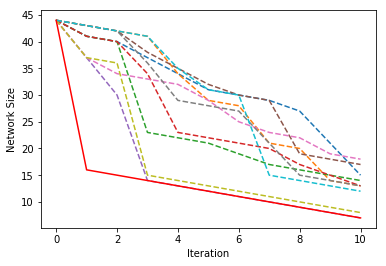

In [76]:
#We analize how the network is affected by
#Removing randomly 10 nodes.
#We do it 10 times
data_to_plot = []
for t in range(0,10):
    G_c = G.copy()
    network_size = []
    network_size.append(len(G_c))
    draw_tree(G_c, str(t) + '_0')
    for r in range(0,10):
        node_to_remove = random.randint(1,len(G_c.nodes()))
        remove_node(G_c,list(G_c.nodes())[node_to_remove - 1])
        draw_tree(G_c, str(t) + '_' + str(r+1))
        network_size.append(len(G_c.nodes()))
    data_to_plot.append(network_size)

#We now analize how network efficiency is affected by
#Removing nodes ordered from highest to lowest level
nodes = []
j = 0
for node in G.nodes():
    nodes.append(tuple((node,level[j])))
    j += 1

nodes = sorted(nodes,reverse=True, key=lambda tup: tup[1])

G_c = G.copy()
network_size = []
network_size.append(len(G_c))

nodes_deleted = 0
n = 0
draw_tree(G_c, 'highest_level_0')
while nodes_deleted < 10:
    if nodes[n][0] in G_c.nodes():
        remove_node(G_c,nodes[n][0])
        nodes_deleted += 1
        draw_tree(G_c, 'highest_level_' + str(nodes_deleted))
        network_size.append(len(G_c.nodes()))
        if network_size[-1] == 0:
            break
    n += 1

for d in data_to_plot:
    plt.plot(d,'--')
plt.plot(network_size,'r')
plt.ylabel('Network Size')
plt.xlabel('Iteration')
plt.savefig('images/exercice5.png')
plt.show()

# Community detection

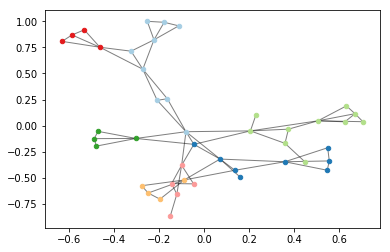

In [35]:
import community

# Get an undirected copy of the graph
G = G.to_undirected()

# First compute the best partition
partition = community.best_partition(G)

# Drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
colors_array = ["#444444", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99",
            "#fdbf6f", "#e31a1c", "#ff7f00", "#cab2d6", "#6a3d9a"]
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 100,
                                node_color = colors_array[count])
    nx.draw_networkx_labels(G, pos)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
nx.draw_networkx_edges(G, edge_color=colors, pos=pos, alpha=0.5)
plt.show()
#nx.draw_kamada_kawai(G, with_labels = True)
